# **PART-1: Dense Network**



In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import numpy as np
from google.colab import drive
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()


# Load the data from the file
data = np.load('/content/drive/MyDrive/Colab Notebooks/emnist_letters.npz')


# Reference the arrays containing images and labels
train_images = torch.tensor(data['train_images'])
train_labels = torch.tensor(data['train_labels'])
val_images = torch.tensor(data['validate_images'])
val_labels = torch.tensor(data['validate_labels'])
test_images = torch.tensor(data['test_images'])
test_labels = torch.tensor(data['test_labels'])

# Create datasets
train_dataset = TensorDataset(train_images, train_labels)
val_dataset = TensorDataset(val_images, val_labels)
test_dataset = TensorDataset(test_images, test_labels)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)



device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")



# Model Definition
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 300, dtype=torch.float32)  # One neuron per feature- each input pixel is a feature, 28 * 28  pixel images, therefore 28 * 28  neurons
        self.fc2 = nn.Linear(300, 175, dtype=torch.float32)  # arbitrarily selecting nerons for each layer, should adjust during model tuning-
        self.fc3 = nn.Linear(175, 50, dtype=torch.float32)
        self.fc4 = nn.Linear(50, 27, dtype=torch.float32)  # 27 Classes present in dataset

    def forward(self, x):
        # x = self.flatten(x)
        # Cast input data to torch.float32
        x = x.to(torch.float32)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x


model = NeuralNetwork()
print(model)

sample_data = torch.rand(1, 28*28)
writer.add_graph(model, sample_data)

# Inspect a sample of the data
for data, target in train_loader:
    print("Target shape:", target.shape)
    print("Target dataset:", target)
    break


# Training
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

def train(model, train_loader, optimizer, criterion, epochs):
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0  # Track epoch loss
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)

            # Convert one-hot encoded target to class labels (One Cold Decoding)
            target_labels = torch.nonzero(target, as_tuple=True)[1]

            # Calculate loss using class labels
            loss = criterion(output, target_labels)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()  # Accumulate batch loss
            writer.add_scalar('Loss/train', loss.item(), epoch * len(train_loader) + batch_idx)

        # Print epoch results
        epoch_loss /= len(train_loader)
        print(f'Epoch {epoch} - Loss: {epoch_loss:.6f}')
        writer.add_scalar('Loss/train_epoch', epoch_loss, epoch)

       # Print epoch results with progress during each epoch
       # if batch_idx % 100 == 0:
       #         print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
       #             epoch, batch_idx * len(data), len(train_loader.dataset),
       #             100. * batch_idx / len(train_loader), loss.item()))



def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            # Convert one-hot encoded target to class labels (1D tensor)
            target_labels = torch.nonzero(target, as_tuple=True)[1]
            test_loss += criterion(output, target_labels).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target_labels.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format( test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))
    writer.add_scalar('Loss/test', test_loss)
    writer.add_scalar('Accuracy/test', accuracy)

train(model, train_loader, optimizer, criterion, epochs=10)
test(model, test_loader)
writer.flush()
writer.close()


Using cpu device
NeuralNetwork(
  (fc1): Linear(in_features=784, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=175, bias=True)
  (fc3): Linear(in_features=175, out_features=50, bias=True)
  (fc4): Linear(in_features=50, out_features=27, bias=True)
)
Target shape: torch.Size([64, 27])
Target dataset: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
Epoch 0 - Loss: 0.796637
Epoch 1 - Loss: 0.379134
Epoch 2 - Loss: 0.299740
Epoch 3 - Loss: 0.256209
Epoch 4 - Loss: 0.226470
Epoch 5 - Loss: 0.203460
Epoch 6 - Loss: 0.183249
Epoch 7 - Loss: 0.166714
Epoch 8 - Loss: 0.153970
Epoch 9 - Loss: 0.142541

Test set: Average loss: 0.0052, Accuracy: 18936/20800 (91%)



# Graphing the data from the Dense network

First, lets generate confusion matrix of the dense network's classifications

We'll start by calculating the number of true and false positives

In [3]:
import numpy as np

# Generate predictions for the test set
def generate_predictions(model, test_loader):
    model.eval()
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            all_predictions.extend(output.argmax(dim=1).cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    return np.array(all_predictions), np.array(all_targets)
def compute_tp_fp(predictions, targets, class_label):
    # Convert one-hot encoded targets to class labels
    target_labels = np.argmax(targets, axis=1)

    # Compute True Positives (TP) and False Positives (FP) for the specified class label
    tp = np.sum((predictions == class_label) & (target_labels == class_label))
    fp = np.sum((predictions == class_label) & (target_labels != class_label))

    return tp, fp

# Generate predictions for the test set
test_predictions, test_targets = generate_predictions(model, test_loader)

# Compute TP and FP for each class
for class_label in range(27):
    tp, fp = compute_tp_fp(test_predictions, test_targets, class_label)
    print(f"Class {class_label}: TP={tp}, FP={fp}")


Class 0: TP=0, FP=0
Class 1: TP=747, FP=114
Class 2: TP=740, FP=44
Class 3: TP=744, FP=35
Class 4: TP=727, FP=64
Class 5: TP=768, FP=74
Class 6: TP=751, FP=48
Class 7: TP=627, FP=137
Class 8: TP=703, FP=42
Class 9: TP=610, FP=240
Class 10: TP=733, FP=41
Class 11: TP=738, FP=43
Class 12: TP=588, FP=194
Class 13: TP=776, FP=46
Class 14: TP=724, FP=69
Class 15: TP=777, FP=61
Class 16: TP=779, FP=32
Class 17: TP=671, FP=140
Class 18: TP=732, FP=67
Class 19: TP=765, FP=28
Class 20: TP=742, FP=36
Class 21: TP=734, FP=73
Class 22: TP=767, FP=114
Class 23: TP=759, FP=19
Class 24: TP=736, FP=19
Class 25: TP=729, FP=49
Class 26: TP=769, FP=35


We will now create the confusion matrix using these values and represent it as a heat map. The diagnol across the center is all of the accurate predictions

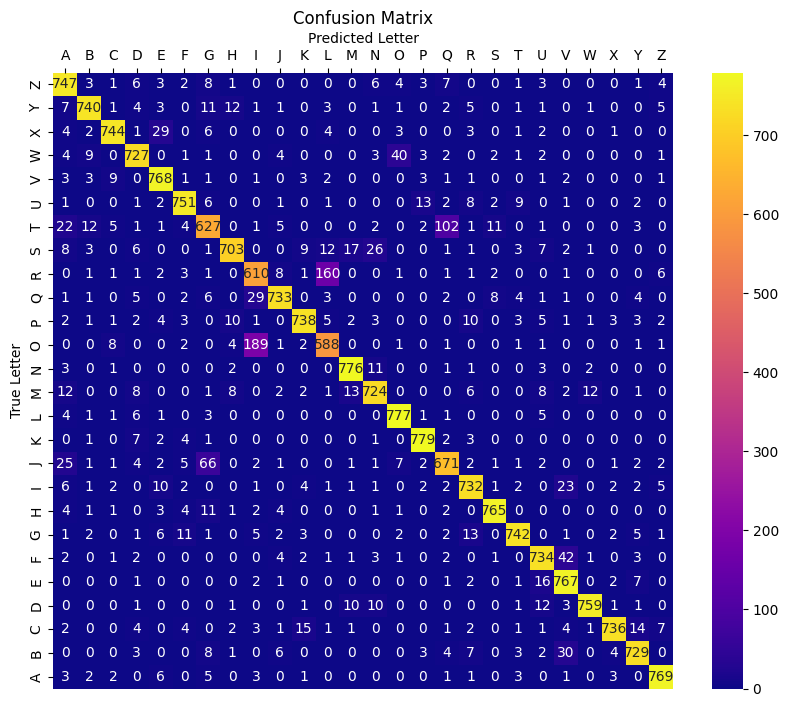

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate predictions for the test set
test_predictions, test_targets = generate_predictions(model, test_loader)

# zero cold decoding
test_targets_single = np.argmax(test_targets, axis=1)

# Compute confusion matrix
cm = confusion_matrix(test_targets_single, test_predictions)


# Generate labels for the letters using Unicode
letter_labels = [chr(ord('A') + i) for i in range(26)]

# Plot confusion matrix as heatmap with x-axis on top and "plasma" colormap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="plasma", xticklabels=letter_labels, yticklabels=letter_labels[::-1])
plt.xlabel("Predicted Letter")
plt.ylabel("True Letter")
plt.title("Confusion Matrix")
plt.gca().xaxis.set_ticks_position('top')  # Move x-axis to the top
plt.gca().xaxis.set_label_position('top')  # Move x-axis label to the top
plt.show()



# Step 5: Comparison
# Compare the performance of your model with the OPIUM-based classifier from the EMNIST paper

# **PART-2: Convolutional Network**

In [8]:
import numpy as np


# Load the data from the file
data = np.load('/content/drive/MyDrive/Colab Notebooks/emnist_letters.npz')

# Access the arrays containing images and labels
train_images = data['train_images']
train_labels = data['train_labels']
validate_images = data['validate_images']
validate_labels = data['validate_labels']
test_images = data['test_images']
test_labels = data['test_labels']

In [9]:
num_train_images = train_images.shape[0]
print("Number of images in the training dataset:", num_train_images)

Number of images in the training dataset: 104000


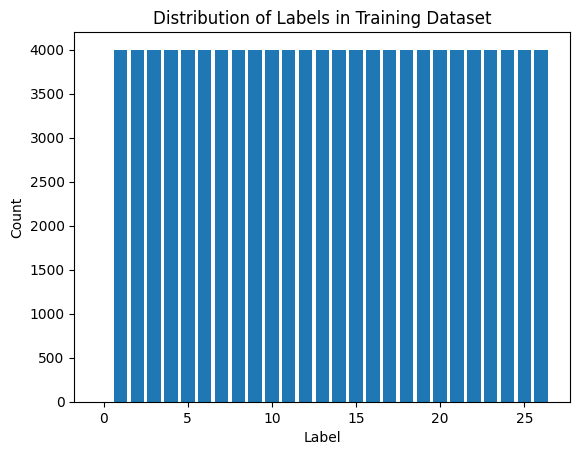

In [10]:
import matplotlib.pyplot as plt

# Count occurrences of each label
label_counts = np.sum(train_labels, axis=0)

# Plot the distribution of labels
plt.bar(range(len(label_counts)), label_counts)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels in Training Dataset')
plt.show()

In [11]:
print(train_images.shape)
print(validate_images.shape)

(104000, 784)
(20800, 784)


In [12]:
!pip install tensorflow

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization, MaxPooling2D, Dropout,Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# Define the strategy
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = Sequential()

    # Reshape the input images to their original 28x28 shape (assuming original shape was 28x28)
    model.add(tf.keras.layers.Reshape((28, 28, 1), input_shape=(784,)))

    # Feature Learning Layers
    model.add(Conv2D(32,                  # Number of filters/Kernels
                     (3,3),               # Size of kernels (3x3 matrix)
                     strides = 1,         # Step size for sliding the kernel across the input (1 pixel at a time).
                     padding = 'same'    # 'Same' ensures that the output feature map has the same dimensions as the input by padding zeros around the input.
                    ))
    model.add(Activation('relu'))# Activation function
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (5,5), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3,3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
    model.add(Dropout(0.3))

    # Flattening tensors
    model.add(Flatten())

    # Fully-Connected Layers
    model.add(Dense(2048))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(27, activation = 'softmax')) # Classification layer

    model.compile(optimizer = tf.keras.optimizers.RMSprop(0.0001), # 1e-4
              loss = 'categorical_crossentropy', # Ideal for multiclass tasks
              metrics = ['accuracy']) # Evaluation metric

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [22]:


# Defining an Early Stopping and Model Checkpoints
early_stopping = EarlyStopping(monitor = 'val_accuracy',
                              patience = 5, mode = 'max',
                              restore_best_weights = True)

checkpoint = ModelCheckpoint('best_model.keras',
                            monitor = 'val_accuracy',
                            save_best_only = True)

In [ ]:
# Define the number of epochs
num_epochs = 50

# Fit the model to the training data
history = model.fit(train_images, train_labels,
                    epochs=num_epochs,
                    validation_data=(validate_images, validate_labels),
                    callbacks=[early_stopping, checkpoint])


Epoch 1/50
3250/3250 ━━━━━━━━━━━━━━━━━━━━ 611s 187ms/step - accuracy: 0.6434 - loss: 1.2669 - val_accuracy: 0.9130 - val_loss: 0.2789
Epoch 2/50
3250/3250 ━━━━━━━━━━━━━━━━━━━━ 610s 188ms/step - accuracy: 0.8831 - loss: 0.3729 - val_accuracy: 0.9224 - val_loss: 0.2543
Epoch 3/50
2390/3250 ━━━━━━━━━━━━━━━━━━━━ 2:36 182ms/step - accuracy: 0.9010 - loss: 0.3110

Generate True and False Positives for Convolutional Network

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model

# Load the best model
best_model = load_model('best_model.keras')

# Generate predictions for the test set
def generate_predictions(model, test_images):
    predictions = model.predict(test_images)
    return np.argmax(predictions, axis=1)

# Load the test data
test_images = data['test_images']
test_labels = data['test_labels']

# Flatten the test labels
test_labels_flat = np.argmax(test_labels, axis=1)

# Compute TP and FP for each class
def compute_tp_fp(predictions, targets, class_label):
    # Compute True Positives (TP) and False Positives (FP) for the specified class label
    tp = np.sum((predictions == class_label) & (targets == class_label))
    fp = np.sum((predictions == class_label) & (targets != class_label))
    return tp, fp

# Generate predictions for the test set
test_predictions = generate_predictions(best_model, test_images)

# Compute TP and FP for each class
for class_label in range(27):
    tp, fp = compute_tp_fp(test_predictions, test_labels_flat, class_label)
    print(f"Class {class_label}: TP={tp}, FP={fp}")


650/650 [==============================] - 2s 3ms/step
Class 0: TP=0, FP=0
Class 1: TP=775, FP=60
Class 2: TP=777, FP=17
Class 3: TP=780, FP=20
Class 4: TP=758, FP=25
Class 5: TP=783, FP=29
Class 6: TP=779, FP=15
Class 7: TP=713, FP=158
Class 8: TP=764, FP=28
Class 9: TP=647, FP=236
Class 10: TP=760, FP=17
Class 11: TP=775, FP=10
Class 12: TP=581, FP=162
Class 13: TP=788, FP=15
Class 14: TP=774, FP=41
Class 15: TP=788, FP=41
Class 16: TP=792, FP=12
Class 17: TP=624, FP=58
Class 18: TP=769, FP=26
Class 19: TP=790, FP=21
Class 20: TP=777, FP=19
Class 21: TP=743, FP=28
Class 22: TP=763, FP=63
Class 23: TP=784, FP=5
Class 24: TP=777, FP=21
Class 25: TP=777, FP=34
Class 26: TP=792, FP=9


Generate Heat Map

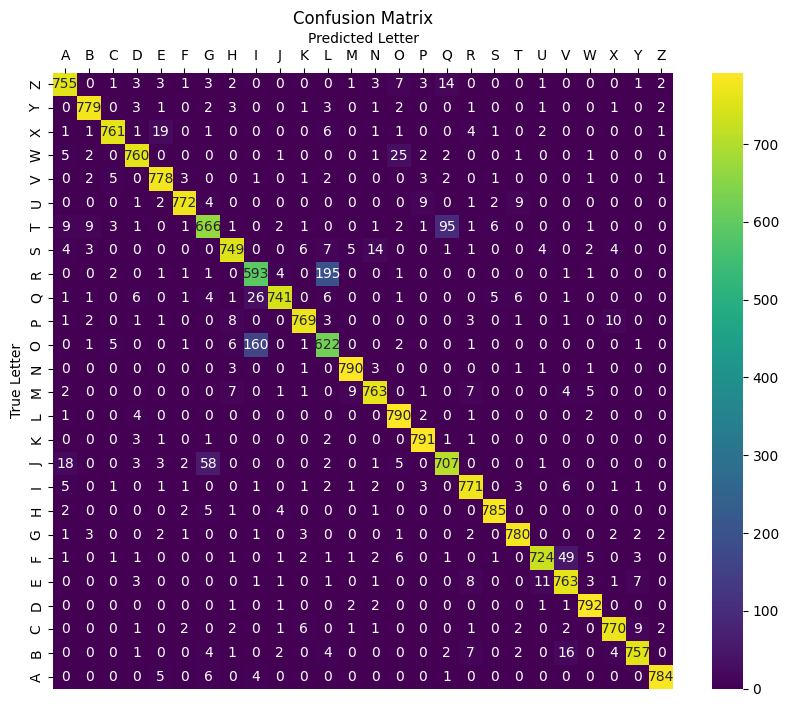

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.models import load_model

# Load the best model
best_model = load_model('best_model.keras')

# Generate predictions for the test set
def generate_predictions(model, test_images):
    predictions = model.predict(test_images)
    return np.argmax(predictions, axis=1)

# Load the test data
test_images = data['test_images']
test_labels = data['test_labels']

# Flatten the test labels
test_labels_flat = np.argmax(test_labels, axis=1)

# Compute confusion matrix
cm = confusion_matrix(test_labels_flat, test_predictions)

# Generate labels for the letters using Unicode
letter_labels = [chr(ord('A') + i) for i in range(26)]

# Plot confusion matrix as heatmap with x-axis on top and "plasma" colormap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", xticklabels=letter_labels, yticklabels=letter_labels[::-1])
plt.xlabel("Predicted Letter")
plt.ylabel("True Letter")
plt.title("Confusion Matrix")
plt.gca().xaxis.set_ticks_position('top')  # Move x-axis to the top
plt.gca().xaxis.set_label_position('top')  # Move x-axis label to the top
plt.show()


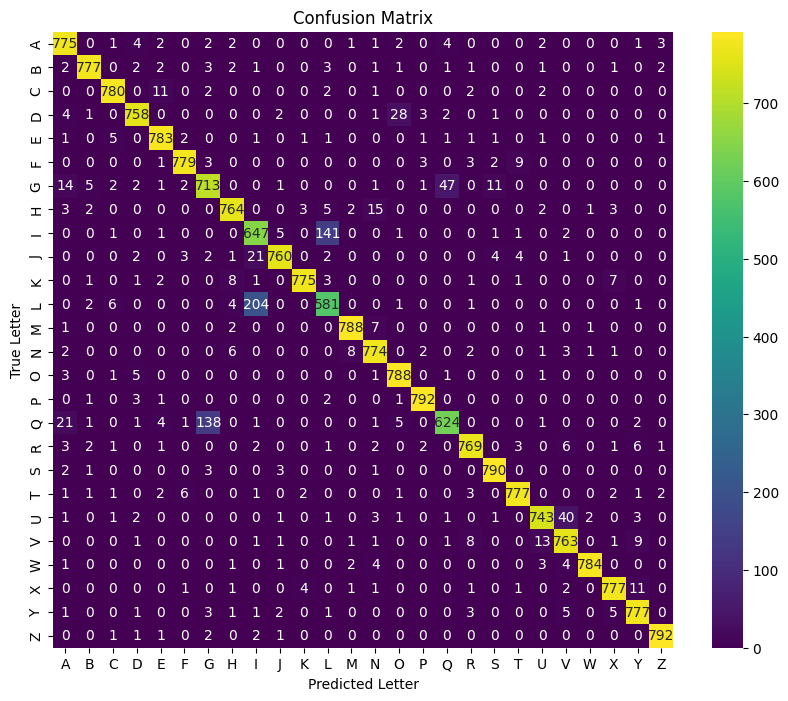

In [ ]:
#Trying changes in confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define class labels (assuming class labels are represented as integers from 0 to 25, corresponding to letters A to Z)
class_labels = range(26)
letter_labels = [chr(ord('A') + i) for i in class_labels]

# Compute confusion matrix
cm = confusion_matrix(test_labels_flat, test_predictions)

# Plot confusion matrix as heatmap with "viridis" colormap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", xticklabels=letter_labels, yticklabels=letter_labels)
plt.xlabel("Predicted Letter")
plt.ylabel("True Letter")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from tensorflow.keras.models import load_model

# Load the best model
best_model = load_model('best_model.h5')

# Evaluate the best model on test data
test_loss, test_accuracy = best_model.evaluate(test_images, test_labels)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

650/650 [==============================] - 2s 3ms/step - loss: 0.1823 - accuracy: 0.9438
Test Loss: 0.18228153884410858
Test Accuracy: 0.9437500238418579
